# Clustering CIML

Clustering experiment on CIML.

**Background:** During supervised learning on multiple classification experiments, the classes predicted with the best metrics were those with the higher amount of samples in the dataset. 
We want to evaluate if unsupervised learning can group those cloud providers with the highest support in separate clusters. 

Clustering algorithm: k-means.
<br>Method for deciding the number of clusters: elbow method and silhouette score.


In [14]:
from ciml import gather_results
from ciml import tf_trainer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as pltcolors
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [139]:
#Define datapath
data_path = '/Users/kw/ciml_data/cimlodsceu2019seed'

In [140]:
#dataset = 'usr_1m-10s-node_provider'
dataset = 'usr_1m-1min-node_provider'

In [141]:
#Dataset including classes
labels = gather_results.load_dataset(dataset, 'labels', data_path=data_path)['labels']
training_data = gather_results.load_dataset(dataset, 'training', data_path=data_path)
test_data = gather_results.load_dataset(dataset, 'test', data_path=data_path)
config = gather_results.load_model_config(dataset, data_path=data_path)
classes = training_data['classes']
examples = training_data['examples']
example_ids = training_data['example_ids']

In [142]:
# Create an int representation of class
unique_classes = list(set(classes))
dict_classes = dict(zip(unique_classes, list(range(len(unique_classes)))))
int_classes = [dict_classes[x] for x in classes]
df_data = pd.DataFrame(examples, columns=labels, index=example_ids)
df_data['classes'] = int_classes

In [143]:
#Let's have a look at the data
df_data.shape

(2377, 185)

In [144]:
df_data.head(3)

,usr0,usr1,usr2,usr3,usr4,usr5,usr6,usr7,usr8,usr9,...,1m83,1m84,1m85,1m86,1m87,1m88,1m89,1m90,1m91,classes
7986256a-5ada-4410-b6a6-ab7395e17f42,0.163779,0.058459,-0.008579,-0.031460,0.038991,-0.021702,0.014113,0.065829,0.103613,-0.110134,...,-0.056533,-0.048451,-0.042802,-0.0402,-0.05631,-0.034836,-0.02871,-0.042958,-0.039393,0
ca45e609-a7af-484c-8098-79f19eeb2f87,-0.020813,-0.023182,0.002118,0.018013,0.082778,0.103562,-0.059077,-0.144860,-0.250860,-0.029941,...,-0.056533,-0.048451,-0.042802,-0.0402,-0.05631,-0.034836,-0.02871,-0.042958,-0.039393,6
89d400ba-a6dd-4a36-bf36-99ddc1799e20,0.125834,0.088577,0.019594,0.014478,-0.213372,-0.078324,0.207520,0.275133,0.010057,-0.049286,...,-0.056533,-0.048451,-0.042802,-0.0402,-0.05631,-0.034836,-0.02871,-0.042958,-0.039393,6


In [219]:
#Cloud providers in the dataset and their numerical mapping
classes_count = pd.DataFrame.from_dict(dict_classes, orient='index').reset_index()
classes_count = classes_count.rename(columns={'index':'cloud_prov',0:'id'})
classes_count

,cloud_prov,id
0,inap-mtl01,0
1,packethost-us-west-1,1
2,vexxhost,2
3,fortnebula-regionone,3
4,limestone-regionone,4
5,rax,5
6,ovh,6


In [220]:
#Add the total amount of samples in the dataset per cloud provider to have an overall view of the dataset
total_count = pd.DataFrame(df_data['classes'].value_counts()).add_suffix('_count').reset_index()

In [221]:
classes_count['count'] = classes_count.apply(
    lambda x: (total_count[total_count['index']==x['id']]['classes_count']).values[0], axis=1, result_type = 'expand')

In [222]:
classes_count.sort_values(by='count', ascending=False)

,cloud_prov,id,count
5,rax,5,1017
6,ovh,6,704
0,inap-mtl01,0,320
2,vexxhost,2,149
4,limestone-regionone,4,103
1,packethost-us-west-1,1,51
3,fortnebula-regionone,3,33


In [223]:
#Numpy representation of the dataframe df_data.
#This representation is needed for calculating the silhouette coefficients.
cluster_examples = df_data.to_numpy()
cluster_examples.shape

(2377, 186)

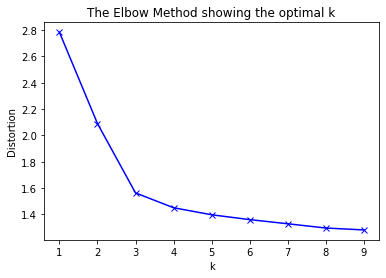

In [224]:
# k means determine k using elbow method
distortions = []
K = range(1,10)
X = cluster_examples
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method suggest running k-means with 3 or 4 clusters.

For n_clusters = 2 The average silhouette_score is : 0.4661635760756616
For n_clusters = 3 The average silhouette_score is : 0.4599452347614555
For n_clusters = 4 The average silhouette_score is : 0.4351180619458827
For n_clusters = 5 The average silhouette_score is : 0.3803200818254573
For n_clusters = 6 The average silhouette_score is : 0.37206569633920156
For n_clusters = 7 The average silhouette_score is : 0.27421094352787484
For n_clusters = 8 The average silhouette_score is : 0.17033843488991018


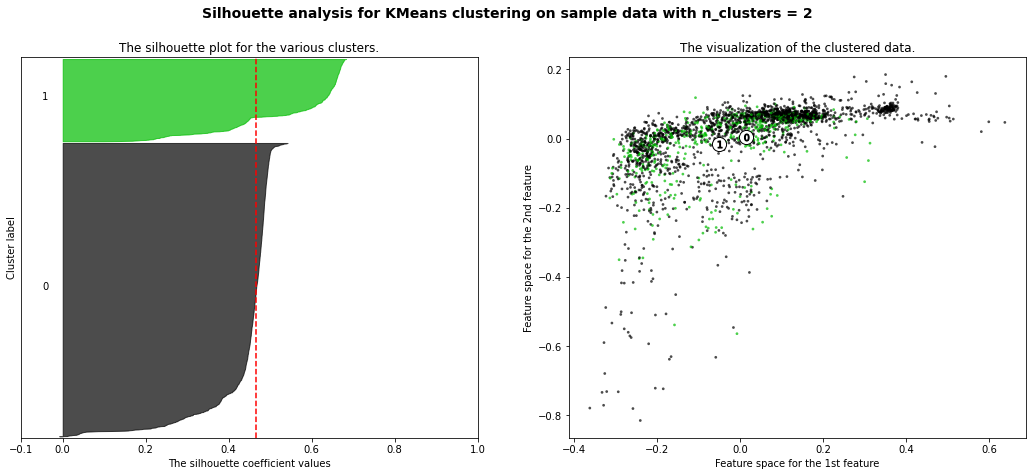

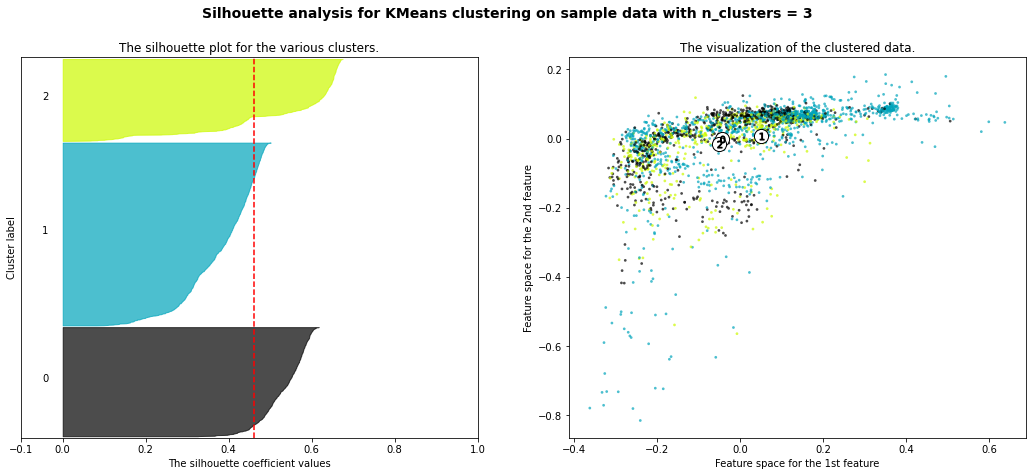

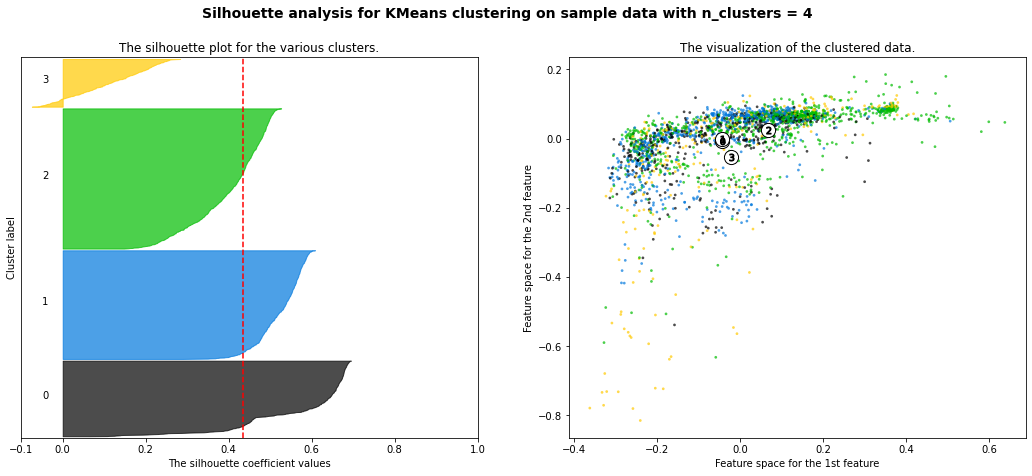

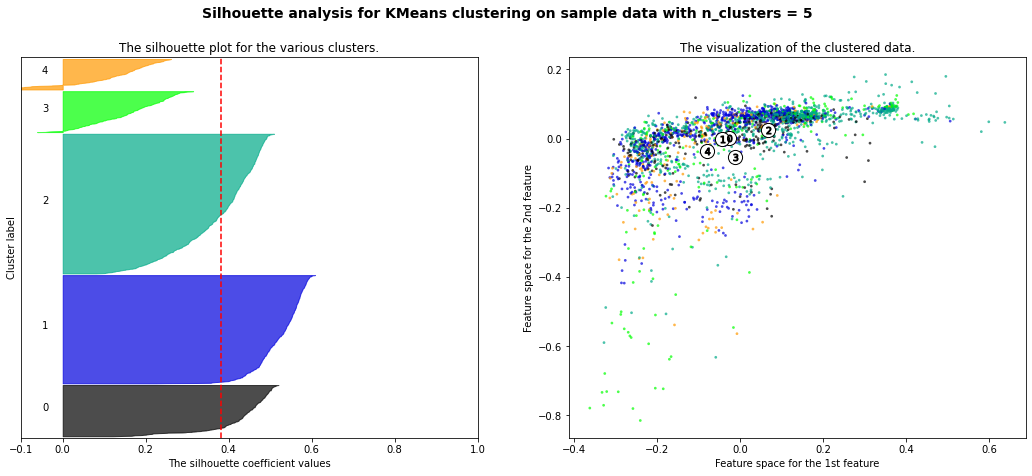

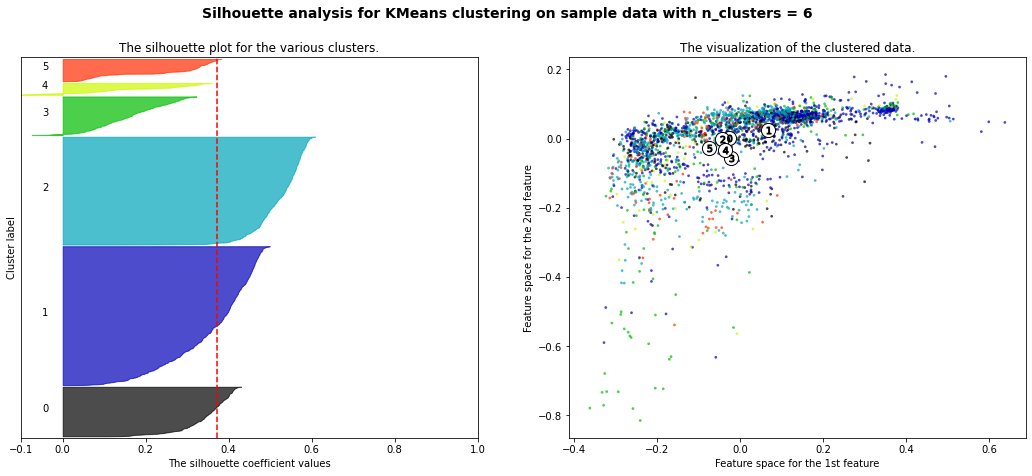

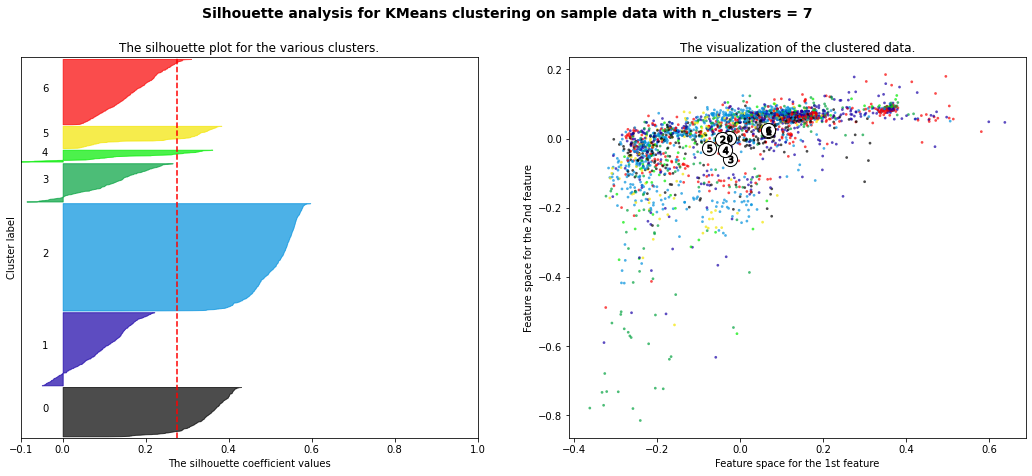

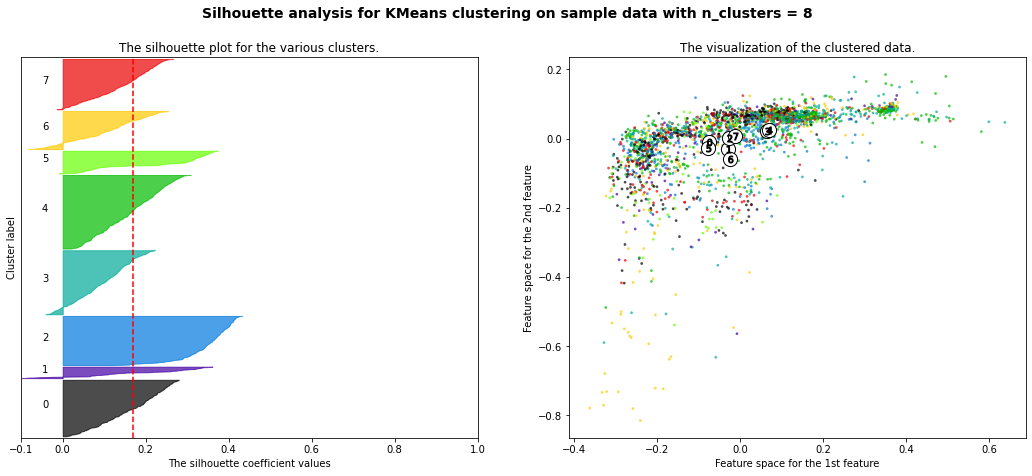

In [225]:
#Silhouette Score
#===============================================
#The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared 
#to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that 
#the object is well matched to its own cluster and poorly matched to neighboring clusters. 
#If most objects have a high value, then the clustering configuration is appropriate. 
#If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
#================================================
X = cluster_examples  
range_n_clusters = (2,3,4,5,6,7,8)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The silhouette coefficient gets lower and lower for more than 4 clusters. 
<br> We run now the experiment with four clusters and evaluate how the cloud providers are grouped in them.

In [226]:
#K-means training using 4 clusters and random state equals to the one used for calculating the sihlouette coefficient. 
clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(X)
k_labels = clusterer.labels_
k_labels.shape

(2377,)

In [228]:
#Create a dataframe with the original dataset and the resulting cluster label found during training of k-means.
data_clusters = df_data
data_clusters['clusters'] = k_labels
classes_totals = data_clusters['classes'].value_counts()

In [229]:
clusters_totals = data_clusters['clusters'].value_counts()
clusters_totals

3    895
0    694
2    483
1    305
Name: clusters, dtype: int64

Let's have an overview of the resulting clustering including:
* list of cloud providers in each cluster.
* percentage of the overall samples of the cloud provider included in the cluster `pclass`.
* percentage of the cluster covered by the cloud provider `pcluster`.

In [230]:
stats = pd.DataFrame(data_clusters.groupby(by=['clusters','classes'])['classes'].count())
stats = stats.add_suffix('_count').reset_index()

In [209]:
stats['p_class'] = (stats.apply(
    lambda x: 100*x['classes_count']/classes_totals[x['classes']], axis=1, result_type = 'expand')).round(2)

In [210]:
stats['p_cluster'] = (stats.apply(
    lambda x: 100*x['classes_count']/clusters_totals[x['clusters']], axis=1, result_type = 'expand')).round(2)

In [214]:
stats['cloud_prov'] = stats.apply(
    lambda x: (classes_count[classes_count['id']==x['classes']]['cloud_prov']).values[0], axis=1, result_type = 'expand')

In [218]:
def highlight_biggestclass(row):
    if row.p_cluster > 50:
        return ['background-color: cyan']*6
    else:
        return ['background-color: white']*6
 
 
stats.style.apply(highlight_biggestclass, axis=1)

,clusters,classes,classes_count,p_class,p_cluster,cloud_prov
0,0,4,1,0.970000,0.140000,limestone-regionone
1,0,5,86,8.460000,12.390000,rax
2,0,6,607,86.220000,87.460000,ovh
3,1,0,320,100.000000,66.250000,inap-mtl01
4,1,1,51,100.000000,10.560000,packethost-us-west-1
5,1,2,111,74.500000,22.980000,vexxhost
6,1,3,1,3.030000,0.210000,fortnebula-regionone
7,2,2,38,25.500000,12.460000,vexxhost
8,2,3,19,57.580000,6.230000,fortnebula-regionone
9,2,4,63,61.170000,20.660000,limestone-regionone
